# Data Science in Finance Conference

14 April 2022 Workshop 11:30-12:30

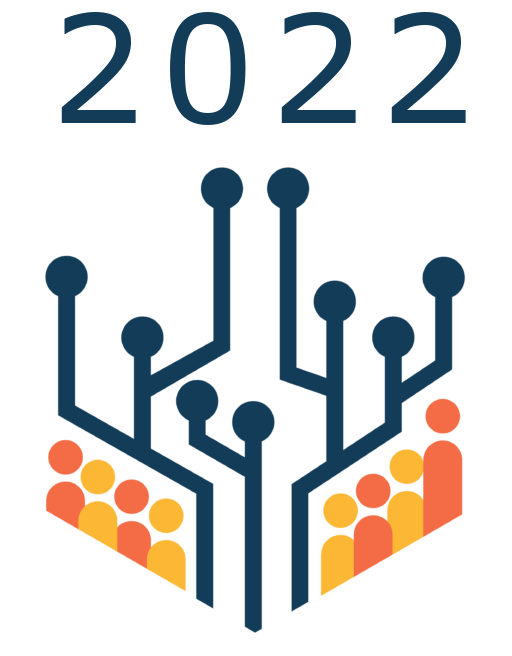

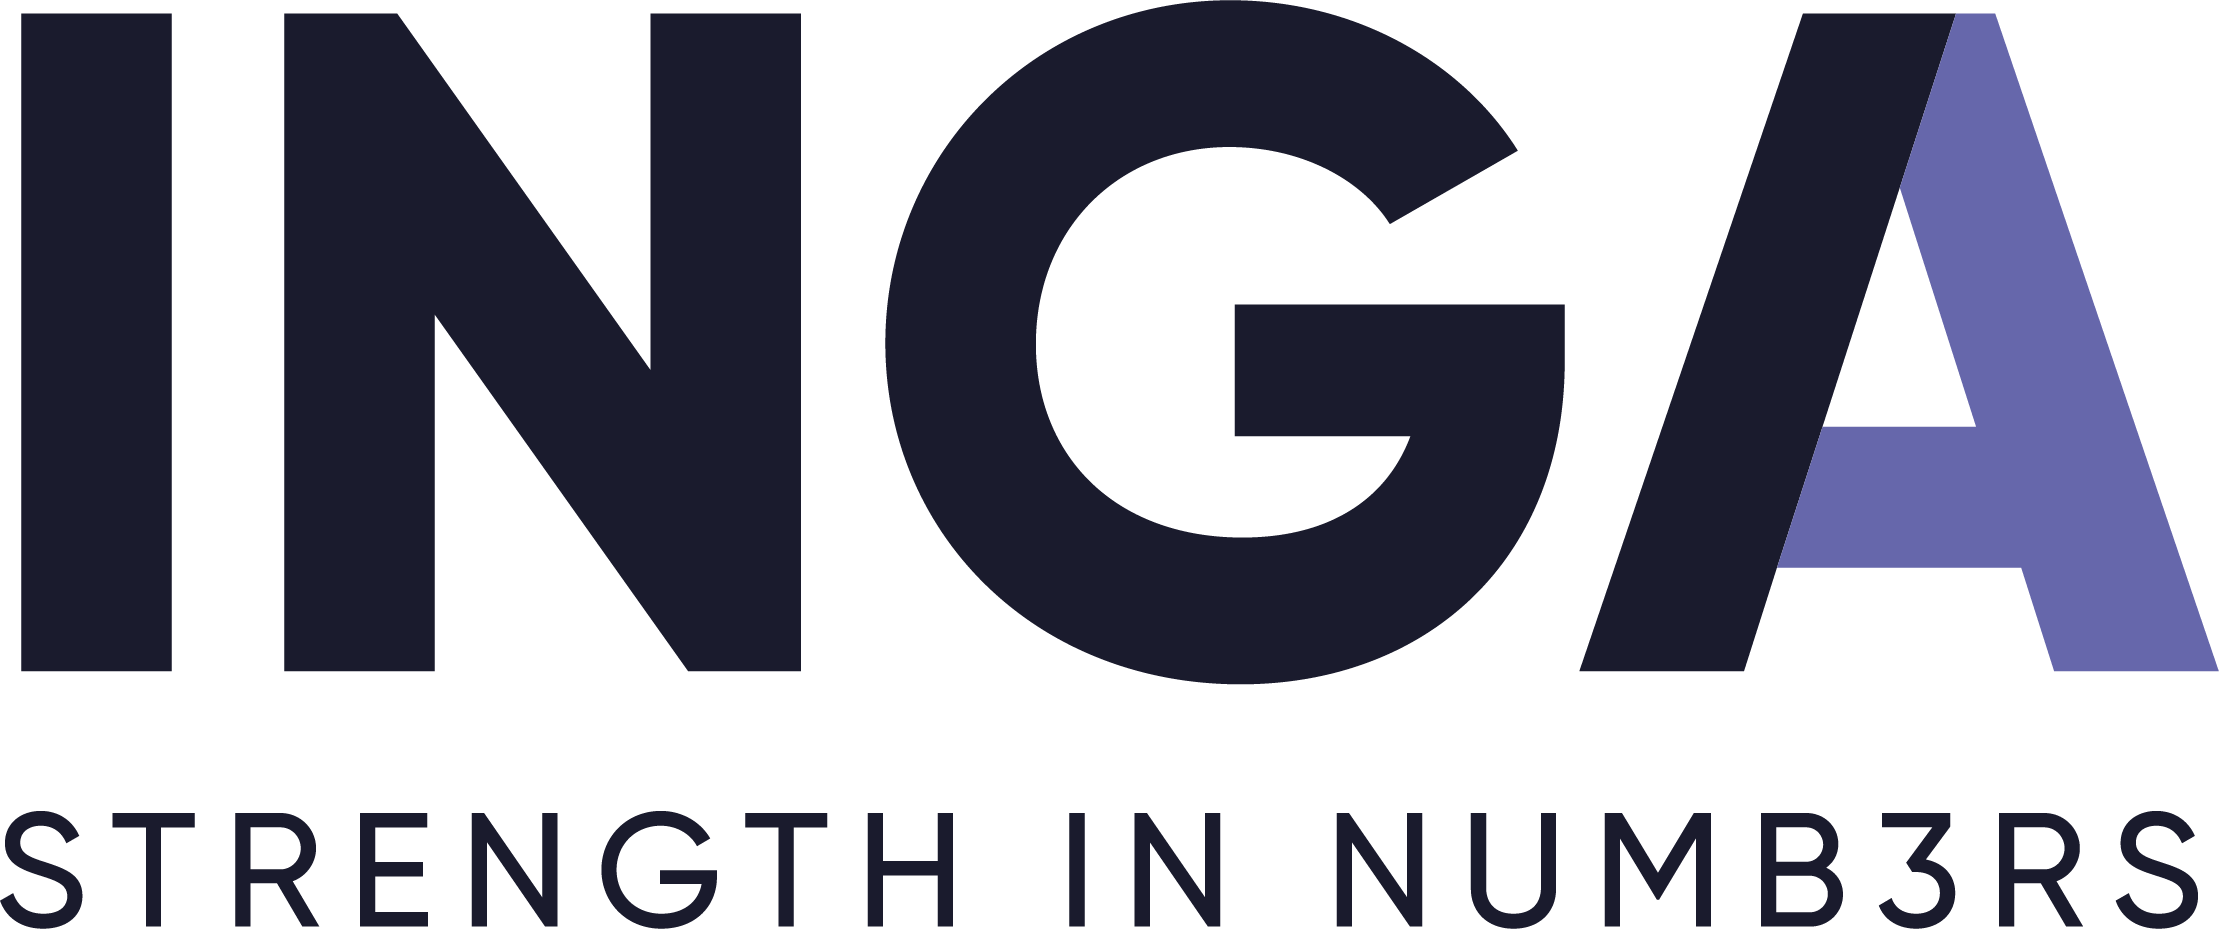

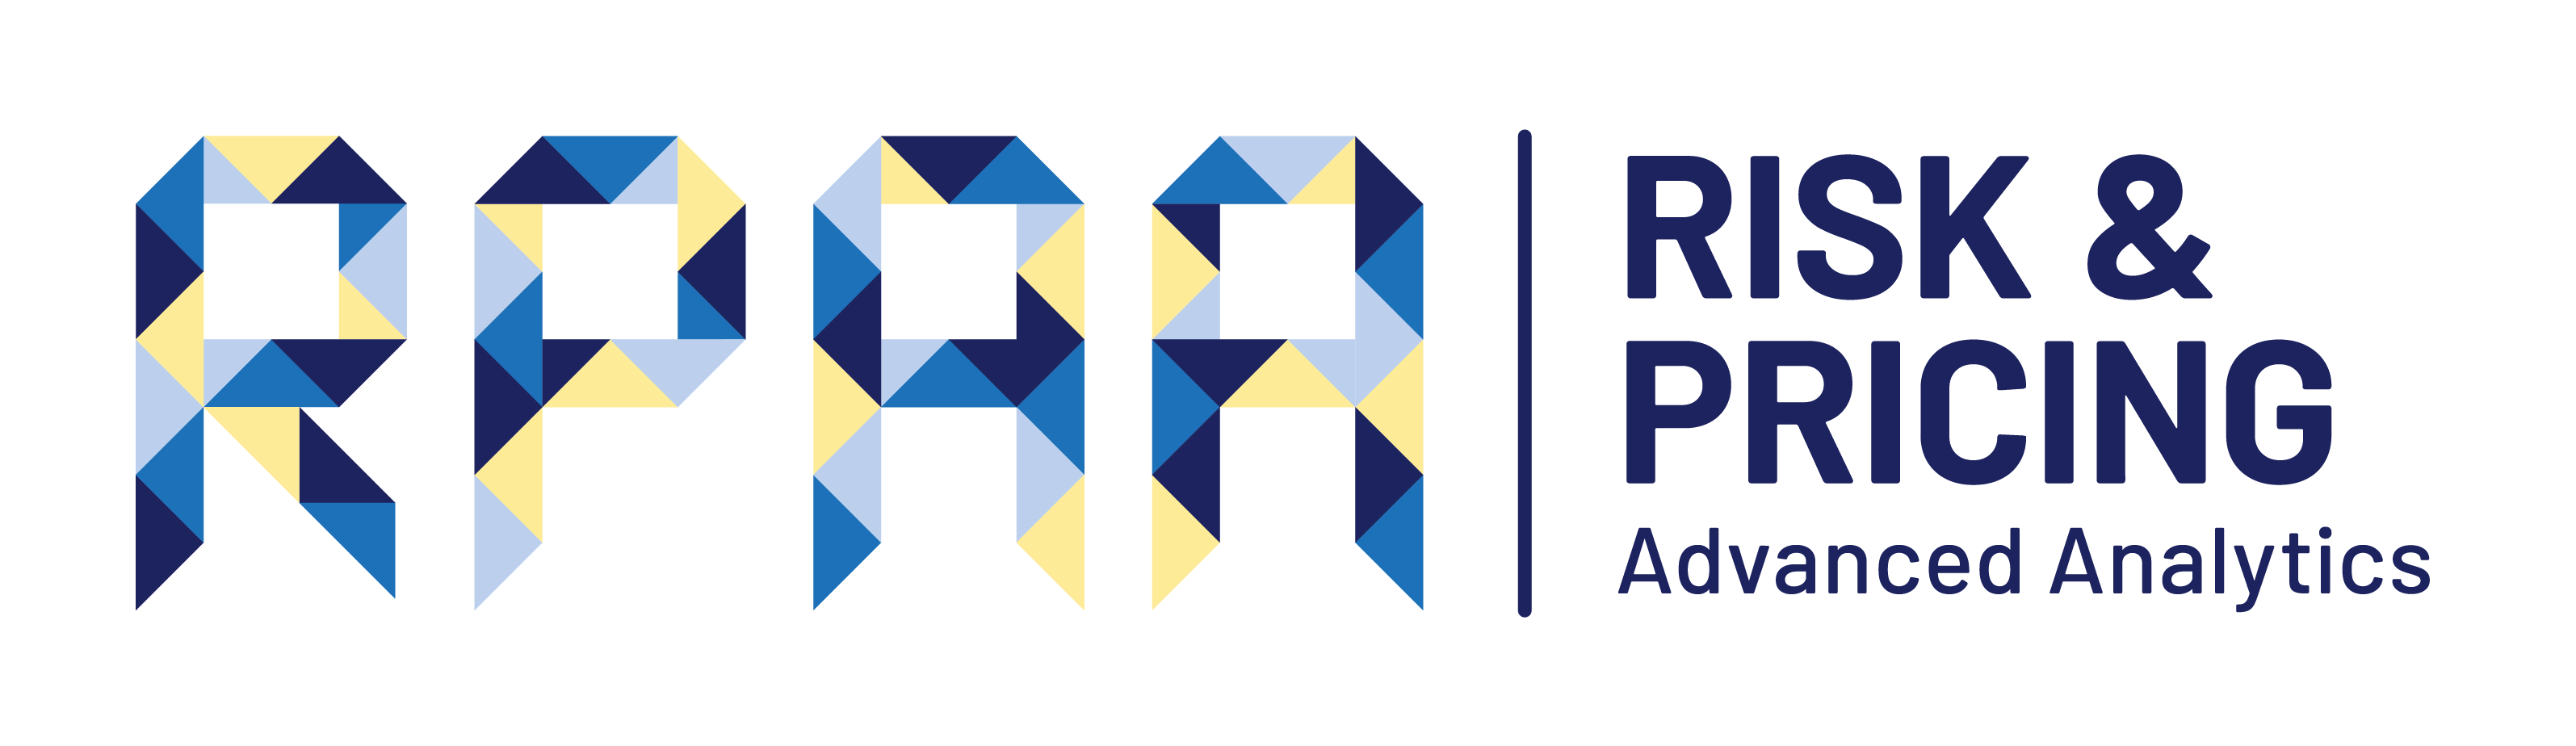

## Smart feature selection with sklearn pipelines, feature-engine, and probatus

* Gilles Verbockhaven (gilles.verbockhaven@ing.com)
* Ryan Chaves (ryan.chaves@ing.com)

Outline of today's workshop:
* Refresher / crash course on `sklearn` pipelines
* Custom transformers
* Feature quality pipeline
* PSI-based feature selection w/ `feature_engine.selection.DropHighPSIFeatures`
* SHAP-based feature selection w/ `probatus.feature_elimination.ShapRFECV`

Requirements:
* Google Colab
* Basic knowledge of Python & Scikit-learn (`sklearn`)

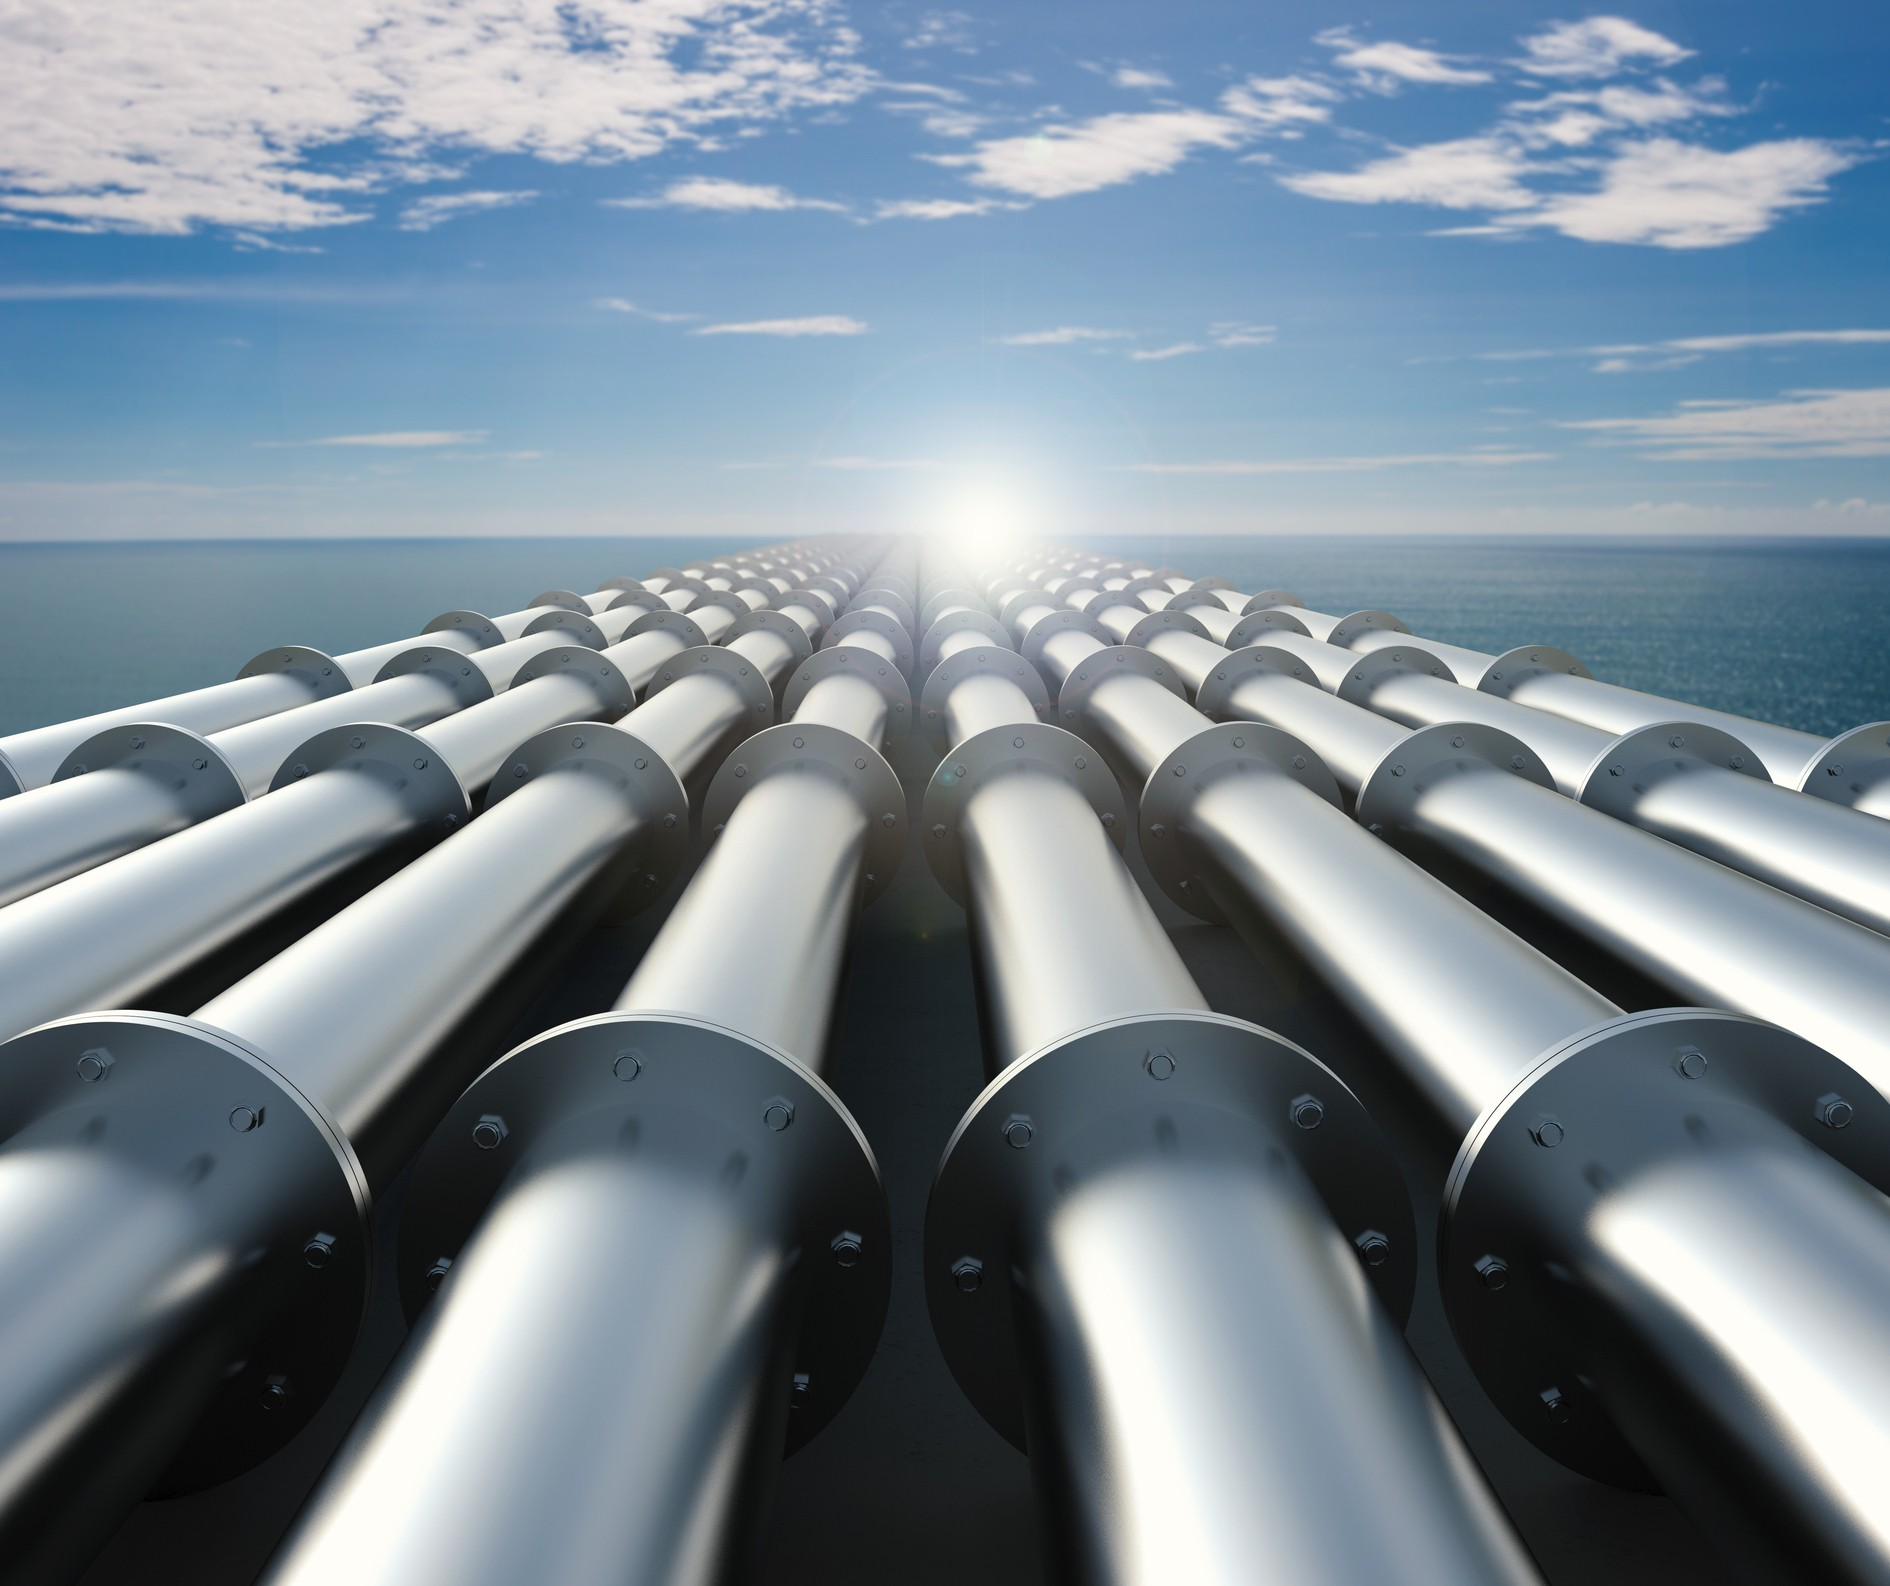

## Refresher / crash course on `sklearn` pipelines

[sklearn pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) allow Data Scientists to stack the different steps of the modelling pipeline, e.g.
* data transformation,
* hyper-parameter tuning, and
* model estimation,

into a single object, called a `Pipeline`.

The `Pipeline` can be fitted on the training data, then used to transform new data and evaluate the model.

Each element of a `Pipeline` must have a `.fit` method. This method defines the action to perform (e.g. remove features with missing values).

The two main families of `Pipeline` components are:

- Transformers: Define how to process data (imputation, outliers, ...).
- Estimators: Fit a model and compute predictions (classifier, grid search engine, ...).

Pipelines are easy to use and are great way to standardize your code -- they ensure that the same treatment is applied to all data sets. There are many standard functionalities (we will show some of them now), plus it's also surprisingly easy to create customized function (classes) to tailor to your needs.

### Setup

Let's create a toy data set to play with and also load the packages we'll need for this notebook.

- For now, we use a small dataset that we artificially create using `sklearn`'s handy `make_classification`.
  - We use 500 observations (rows).
  - We keep things simple, using the default values for the number of relevant, redundants, ... features.
- We also already load the `Pipeline` class from `sklearn`.

In [2]:
# This handy line of code allows your notebook cells to adjust to the width of your browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

We make our own data creating function so that we can directly play with dataframes. 

In [3]:
# This is just a small wrapper around make_classification, helps with column naming, and inserts some missing values (NaNs).
def make_X_y():
    X, y = make_classification(n_samples=500)
    X = pd.DataFrame(X)
    X.columns = ['var_' + str(i) for i in range(0, X.shape[1])]
    y = pd.Series(y)
    nan_loc = [(2, 3), (17, 1), (4, 12)]
    for loc in nan_loc:
        X.iloc[loc] = np.nan
    
    return X, y

X, y = make_X_y()

In [4]:
X.sample(4)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19
395,1.151450,0.416487,-0.346822,-1.447754,-0.914910,-0.131026,-0.110458,0.376145,0.806403,2.316295,-0.308615,-0.389561,-1.030526,0.375294,-0.617399,-0.613119,-1.312351,-1.102876,-0.360618,1.530625
479,-0.597734,0.247745,0.579614,-0.885004,0.549048,0.614929,0.345605,0.521997,0.578709,-0.897692,-1.940570,-1.331360,0.036235,-0.680674,0.586826,-0.830848,1.054461,0.292833,-0.294215,0.321206
167,-0.942863,-0.235844,0.507577,-1.402129,-1.181846,-1.495674,-0.174169,-0.113015,-0.985826,1.461751,-0.056422,-0.982943,1.006617,0.918435,-0.809112,0.105351,0.952812,-2.267284,1.597049,0.858562
173,2.215113,-0.480894,-0.599666,2.129791,0.918557,1.631714,-2.104111,0.726556,2.136777,1.013823,0.416250,1.078448,-2.275248,-0.491841,0.694692,-0.731712,-2.305572,-1.220789,1.547820,-0.199215


As in a real use case, we split the data into train and test sets. For this we use `sklearn`'s handy `train_test_split` with the default values.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Creating a full modelling pipeline

Let's create our first `Pipeline`. It will do the following:

- Impute the missing values.
- Scale the features using `MinMaxScaler`.
- Fit and evaluate a `RandomForestClassifier` model.

In [6]:
# Let's load the required modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

#### Define the pipeline

A `Pipeline` is defined by a series of steps. Each step contains a label and an object. The object can be either a transformer or an estimator.
- In the definition of the `Pipeline`, the objects are initiated.
- If the objects do not have the required method (e.g. `.fit`, `.transform`, `.predict`), the `Pipeline` will fail.

In [7]:
model = Pipeline(
    steps = [
        ("Impute", SimpleImputer(strategy="mean")),
        ('scaler', MinMaxScaler()),
        ("clf", RandomForestClassifier(max_depth=3))
    ]
)

Fitting the pipeline will do the following:
- Compute the value for imputation.
- Compute the scaling factor (after imputation).
- Train the Random Forest (RF) classifier on the imputed and scaled train data set.

In [8]:
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('Impute', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('clf', RandomForestClassifier(max_depth=3))])

#### Maing predictions

The `Pipeline` can now be used on the test data set to evaluate the model performance on unseen data.

In [15]:
from sklearn.metrics import roc_auc_score

prediction = model.predict_proba(X_test)[:, 1]
print('AUC =', round(roc_auc_score(y_test, prediction), 3))

AUC = 0.922


#### Pushing a bit further

In the `Pipeline`, we can also include hyperparameter optimization and model evaluation via cross-validation. This allows o.a. to perform model tuning at different steps of the pipeline.

To illustrate this, use the `Pipeline` defined above and define 3 hyperparameters we want to tune:
- The scaling strategy: `StandardScaler` vs `MinMaxScaler`.
- The maximum depth of the RF.
- The number of estimators (trees) in the RF.

## Pushing a bit further

In the pipeline, we can also `include cross-validation`. This allows o.a. to perform model tuning at different level of the pipeline.
To illustrate this, use the pipeline defined above and define 3 parameters we want to tune:
- The scaler: Standard vs MinMax.
- The maximum depth of the random forest.
- The number of estimators of the random forest.


In [20]:
from sklearn.preprocessing import StandardScaler

parameters = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'clf__max_depth': [3, 5, 7],  # Note the double underscore notation that allows you to access the parameters of the clf object
    'clf__n_estimators': [10, 25, 50, 100],
    }

To optimize the pipeline, we will use randomized grid search ([sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)) with 10 iterations in the 3 dimensional space of hyperparameters.

To do so, we provide the `Pipeline` as input to the grid search object.

In [23]:
from sklearn.model_selection import RandomizedSearchCV

grid = RandomizedSearchCV(model, parameters, cv=5, n_iter=10).fit(X_train, y_train)

print('Train AUC =', round(grid.score(X_train, y_train), 3))
print('Test  AUC =', round(grid.score(X_test, y_test), 3))

Train AUC = 0.944
Test  AUC = 0.896


We can retrieve the best combination of hyperparameters:

We can then see the best combination of parameters

In [24]:
grid.best_params_

{'scaler': MinMaxScaler(), 'clf__n_estimators': 50, 'clf__max_depth': 5}

and the corresponding best `Pipeline`:

In [25]:
grid.best_estimator_

Pipeline(steps=[('Impute', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('clf', RandomForestClassifier(max_depth=5, n_estimators=50))])

Often, it is useful to look at the full set of results. (Actually, you should _never_ just blindly use the `best_params_` or `best_estimator_` methods!)

In [26]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,param_clf__n_estimators,param_clf__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017381,0.001314,0.002816,0.000317,StandardScaler(),10,7,"{'scaler': StandardScaler(), 'clf__n_estimator...",0.866667,0.973333,0.946667,0.893333,0.866667,0.909333,0.043328,9
1,0.060245,0.004263,0.004731,0.000310,StandardScaler(),50,7,"{'scaler': StandardScaler(), 'clf__n_estimator...",0.906667,0.960000,0.946667,0.906667,0.866667,0.917333,0.033092,5
2,0.055504,0.000921,0.004503,0.000039,MinMaxScaler(),50,5,"{'scaler': MinMaxScaler(), 'clf__n_estimators'...",0.906667,0.960000,0.960000,0.920000,0.893333,0.928000,0.027455,1
3,0.032649,0.003201,0.003486,0.000406,MinMaxScaler(),25,5,"{'scaler': MinMaxScaler(), 'clf__n_estimators'...",0.893333,0.960000,0.933333,0.906667,0.866667,0.912000,0.032221,8
4,0.014299,0.001694,0.002619,0.000629,StandardScaler(),10,3,"{'scaler': StandardScaler(), 'clf__n_estimator...",0.880000,0.960000,0.920000,0.906667,0.840000,0.901333,0.040089,10
5,0.128832,0.009334,0.010063,0.001505,StandardScaler(),100,7,"{'scaler': StandardScaler(), 'clf__n_estimator...",0.906667,0.973333,0.933333,0.906667,0.880000,0.920000,0.031552,4
6,0.102169,0.000527,0.007483,0.000174,StandardScaler(),100,3,"{'scaler': StandardScaler(), 'clf__n_estimator...",0.893333,0.960000,0.946667,0.920000,0.893333,0.922667,0.027195,2
7,0.013983,0.000319,0.002163,0.000093,MinMaxScaler(),10,7,"{'scaler': MinMaxScaler(), 'clf__n_estimators'...",0.906667,0.946667,0.946667,0.933333,0.853333,0.917333,0.035176,5
8,0.032220,0.001994,0.003257,0.000221,StandardScaler(),25,7,"{'scaler': StandardScaler(), 'clf__n_estimator...",0.893333,0.973333,0.946667,0.893333,0.866667,0.914667,0.039192,7
9,0.014189,0.001005,0.002357,0.000271,MinMaxScaler(),10,5,"{'scaler': MinMaxScaler(), 'clf__n_estimators'...",0.893333,0.973333,0.933333,0.933333,0.880000,0.922667,0.033092,2


The end of this notebook.